# **Introdução da referência**

Até agora vimos como resolver o problema da regulação de estados apenas para zerar o estado final. No entanto, o objetivo do controle é fazer a saída rastrear a referência $r$.


Uma forma simples de fazer isso é usando o sinal de controle:

$$
\begin{align*}
u &= -\mathbf{Kx}+Nr
\end{align*}
$$
onde $\mathbf{K}$ é o vetor de ganhos conforme já definimos e $N$ é calculado como:

$$
\begin{align*}
N = \frac{1}{\mathbf{C}(\mathbf{BK-A})^{-1}\mathbf{B}}
\end{align*}
$$


Este último resultado garante que o ganho em regime permanente do sistema $G(0)=Y(0)/R(0)$ é unitário. Em outras palavras, o erro de regime será nulo. 

É interessante visualizar como essa estratégia funciona do ponto de vista da rota de sinal. Estude a figura 7.15(b) a seguir:
<p align="center">
<img src="Fig7.15.svg" width="100%">
</p>

Repare que a parte (b) mostra que o controle funciona como uma realimentação negativa normal do sistema, mas a referência entra na malha multiplicada por uma constante.

## **Exemplo**

<p align="center">
<img src="Ex.7.18.svg" width="80%">
</p>

Esse é o sistema do pêndulo novamente. As matrizes $\mathbf{A}$ e $\mathbf{B}$ já são conhecidas. Também usaremos:

$$
\begin{align*}
\mathbf{C} &=\left[\begin{array}{cc}1 & 0\end{array}\right]\\
D &=0
\end{align*}
$$

In [2]:
# Imports
import numpy as np
from escrever import *
import control as ct
from IPython.display import display, Math
esc = escrever()

In [3]:
# Define as matrizes do sistema
w0 = 1
A = np.matrix([[0,1],[-w0**2,0]])
B = np.matrix([[0],[1]])
C = np.matrix([[1,0]])
D = np.matrix([[0]])
esc.sist(A,B,C,D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# Projete o regulador normalmente
polos = [-2*w0,-2*w0]
K = ct.acker(A,B,polos)
display(Math(r'\mathbf{K} = ' + esc.mat(K)))

<IPython.core.display.Math object>

In [5]:
# Calcula N usando a expressão de ganho unitário
N = 1/(C @ np.linalg.inv(B@K-A) @ B)
display(Math(r'{N} = ' + esc.mat(N)))

<IPython.core.display.Math object>

Note que a conta matricial em Python faz com que $N$ seja uma matriz 1x1. Atente a isso na hora de introduzir o resultado em outros contextos. 

### Simulação em malha fechada

É interessante testar o projeto agora usando uma resposta ao degrau. Note que para isso, precisamos definir o sistema em malha fechada.

Substituindo $u=-\mathbf{Kx}+Nr$ na equação de estados vemos que as matrizes $\mathbf{A}$ e $\mathbf{B}$ em malha fechada mudam. A saída permanence a mesma, logo a matriz $\mathbf{C}$ de malha fechada permanece a mesma. 

Em malha fechada (i.e., ganhos realimentados), as equações do sistema ficam:
\begin{align}
    \mathbf{\dot{x}} &= \mathbf{(A-BK)x} +\mathbf{B}Nr\\
    y &= \mathbf{Cx}
\end{align}

A seguir simulamos o sistema.

In [6]:
# Calcula as matrizes de malha fechada
Amf = A - B@K
Bmf = B@N
display(Math(r'\mathbf{A}_{\text{mf}} = \mathbf{A-BK} = ' + esc.mat(A) + '-' + esc.mat(B) + esc.mat(K)))
display(Math(r'\mathbf{A}_{\text{mf}} = ' + esc.mat(Amf) ))
display(Math(r'\mathbf{B}_{\text{mf}} = \mathbf{B}N = ' + esc.mat(B) + f'{N}' + '=' + esc.mat(Bmf)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
# Define o sistema em MF e calcula resposta ao degrau unitário
import control as ct
sys = ct.ss(Amf,Bmf,C,D)
esc.sist(Amf,Bmf,C,D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
# Relatório de pólos em MF
tab = ct.damp(sys)

_____Eigenvalue______ Damping___ Frequency_
        -2                     1          2
        -2                     1          2


In [9]:
# Zeros de transmissão
ct.zeros(sys)

array([], dtype=complex128)

O sistema não tem zeros e os pólos foram alocados em $-2$ e $-2$.

In [10]:
# Simula o sistema para uma resposta ao degrau
t,y = ct.step_response(sys,7)

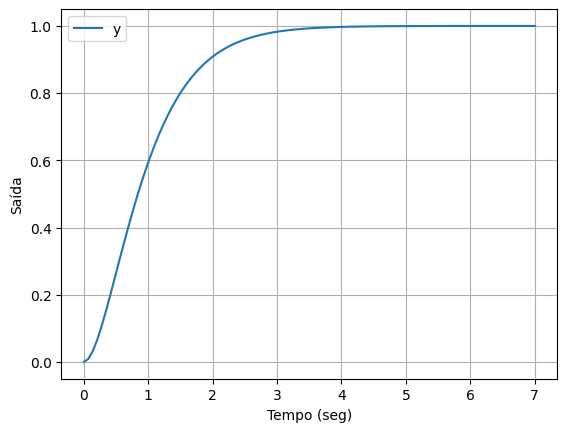

In [11]:
# Plota os resultados, com algumas legendas
import matplotlib.pyplot as plt
plt.plot(t,y)
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('Saída')
plt.legend('y')
plt.show()

Observação: em uma simulação em MF, é sempre importante analisar o sinal de controle resultante. Com modelos em espaço de estados, basta adicionar $u=-\mathbf{Kx}+Nr$ como uma segunda saída do sistema, e o sinal estará disponível para análise. Veja como fazer no código a seguir. 

In [12]:
C2 = np.block([[C],[-K]])
D2 = np.array([[0],[N]])
sys2 = ct.ss(Amf,Bmf,C2,D2)
t,y = ct.step_response(sys2, 7)

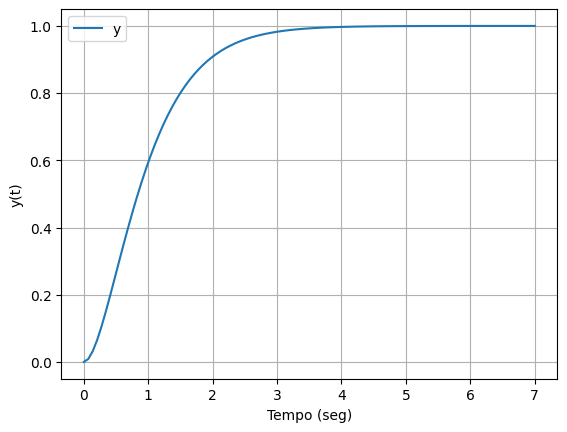

In [13]:
plt.plot(t,y[0,0,:],label='y(t)')
plt.legend('y(t)')
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('y(t)')
plt.show()

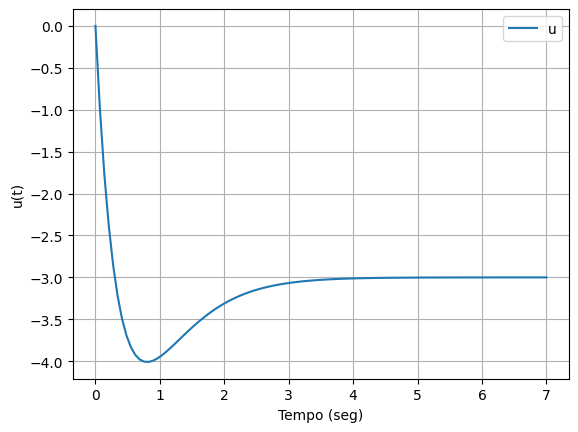

In [14]:
plt.plot(t,y[1,0,:])
plt.legend('u(t)')
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('u(t)')
plt.show()

### Simulação de perturbações

Um dos problemas com a estratégia acima é falta de robustez do sistema, isto é, ele não consegue rejeitar distúrbios.

Distúrbios podem ser modelados como sinais de entrada adicionais ao sistema, cuja forma e a ocorrência não dependem do projetista, diferente do sinal de referência. 

Distúrbios no modelo normalmente representam falhas de componentes físicos do sistema ou erros de modelagem. 

Podemos adicionar distúrbios arbitrários nas nossas simulações introduzindo colunas extras na matriz $\mathbf{B}$ do sistema (malha aberta ou fechada). 

A forma exata das novas colunas depende de como modelamos o distúrbio; normalmente setamos apenas um elemento diferente de zero, simulando uma perturbação em um dos estados do sistema (portanto, um distúrbio interno). No entanto, projetos mais minuciosos podem modelar isso de formas diferentes. 

Observe no código abaixo como modelar e simular um distúrbio no sistema anterior no segundo estado do sistema. 

In [15]:
# Simulação de uma perturbação
Bmf2 = np.block([Bmf, np.array([[0],[1]])])
Cmf2 = np.block([[C],[-K]])
Dmf2 = np.block([[D, 0],[N, 0]])
mf = ct.ss(Amf,Bmf2,Cmf2,Dmf2)
esc.sist(Amf,Bmf2,Cmf2,Dmf2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Agora podemos simular. Note que precisamos criar dois sinais de entrada, então vamos usar um comando de simulação diferente. 

Nossos sinais de entrada serão os seguintes. O sinal de referência será um degrau unitário normal, iniciado em $t=0$. A segunda entrada, o distúrbio, será um degrau de amplitude 0.5 iniciando em $t=3$. Esse tipo de modelagem é interessante porque simula a entrada de um novo sinal desconhecido depois do sistema já ter atingido regime permanente. 

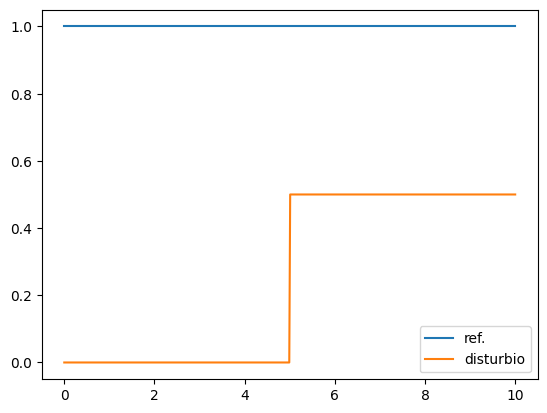

In [16]:
# Simulação do distúrbio
num_pontos = 500
t = np.linspace(0,10,num=num_pontos)
deg = lambda t: t>=0
u = np.zeros((2,num_pontos))
u[0,:] = deg(t)
u[1,:] = 0.5*deg(t-5)
plt.plot(t,u.T)
plt.legend(['ref.', 'disturbio'])
plt.show()

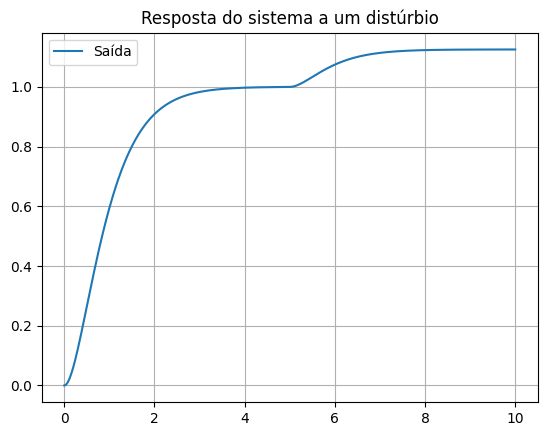

In [17]:
# Simulação da
t,y = ct.forced_response(mf,t,u)
plt.plot(t,y[0,:])
plt.grid()
plt.legend(['Saída'])
plt.title('Resposta do sistema a um distúrbio')
plt.show()

Como você pode ver, o ganho de regime unitário não é suficiente para fazer o sistema rejeitar entradas do tipo distúrbio. Isso pode ser contornado com controle integral, que é o próximo assunto. 